## Audio Explorer Design
sketch out ways to interact with audio, it's features, and outputs of models 

In [ ]:
import sys
import os
import numpy as np
import pandas as pd
sys.path.insert(0, '../../')
from library.notebook_api.data_loader import  ModelDataLoader,CombinedDataLoader
from library.source_data.feature_extractor import AudioFeatureExtractor
from library.source_data.parallel_processor import AudioParallelProcessor
from configuration import PROJECT_ABSOLUTE_PATH,MODEL_INPUT_DATA_PATH
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import base64
from io import BytesIO

## Load Data

### Source Data

In [2]:
#instantate data_loader and the dataframes it makes available 
in_scope_labels = ['rock', 'electronic', 'hiphop', 'classical', 'jazz','country']

data_loader = CombinedDataLoader('large', in_scope_labels)
df = data_loader.df
df_files_available = data_loader.df_files_available
df_genres_available = data_loader.df_genres_available
df_filtered = data_loader.df_filtered
df_filtered_in_scope = df_filtered#[df_filtered['label'].apply(lambda label: True if label in in_scope_labels else False)]

tracks in meta 29701
tracks with files available in project_data_path:  29701
tracks with top level genres available 29701
tracks with genres and files (df_filtered) 29701


### Model Outputs

In [3]:
#unsupervised and supervised results 
clusters = pd.read_csv(MODEL_INPUT_DATA_PATH+'clusters.csv')[['audio_path' , 'label', '0']]
predicted_genres = pd.read_csv(MODEL_INPUT_DATA_PATH+'predicted_prob.csv')
combined_df = predicted_genres.merge(clusters, on='audio_path')
combined_df.drop(columns=['index','label'], inplace=True)

In [187]:
len(predicted_genres), len(combined_df)

(5870, 5870)

### Load Features Into Memory

In [4]:
SAMPLE_RATE  = 22500
SECONDS = 6
#SECONDS = 25

#combined model outputs, inner joined with source data
source_data_and_model_output_df = pd.merge(df_filtered_in_scope, combined_df, on='audio_path')
#load dataframe of 1 track per label randomly sampled from above
df_filtered_in_scope_sample = data_loader.get_data_sampled_by_label(1,source_data_and_model_output_df)
#instantiate the audio extracter to laod features to memory
audio = AudioFeatureExtractor(df_filtered_in_scope_sample,sample_rate=SAMPLE_RATE,start_sample=0,end_sample=SAMPLE_RATE*SECONDS)
audio.add_audio_data_to_df()
audio.add_numerical_features_to_df()
audio.add_mfcc_to_df()
audio.add_log_melspectrogram_to_df()

/Users/murphybre/Desktop/UMichigan/Fall2024/siads699_capstone/music_modeling_capstone/notebooks/exploratory/../../library/source_data/feature_extractor.py:139: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]


In [5]:
audio.df.head()

track_id dataset  \
2454  rock.00003.wav   gtzan   
2098          134554     fma   
1545          074645     fma   
1959          117213     fma   
817           036151     fma   

                                             audio_path       label  \
2454  /project_data_source/gtzan_dataset/Data/genres...        rock   
2098  /project_data_source/free_music_archive/fma_la...  electronic   
1545  /project_data_source/free_music_archive/fma_la...      hiphop   
1959  /project_data_source/free_music_archive/fma_la...   classical   
817   /project_data_source/free_music_archive/fma_la...        jazz   

     fma_genre_top fma_genres fma_genres_all  file_available      rock  \
2454           n/a        n/a            n/a             1.0  0.000184   
2098    Electronic      [181]      [181, 15]             1.0  0.000059   
1545       Hip-Hop      [100]      [100, 21]             1.0  0.000005   
1959     Classical      [659]       [659, 5]             1.0  0.000014   
817           Jazz       [74]        [74, 4]             1.0  0.000008   

        electronic  ...   country      y_pred      y_true  0  \
2454  1.249301e-01  ...  0.107280        jazz        rock  0   
2098  2.536747e-06  ...  0.001103  electronic  electronic  1   
1545  1.161098e-07  ...  0.001806  electronic      hiphop  0   
1959  7.639396e-05  ...  0.243305  electronic   classical  2   
817   6.976748e-02  ...  0.899194        rock        jazz  0   

                                audio_and_sampling_rate  \
2454  ([-0.09442139, -0.14968872, -0.13104248, -0.13...   
2098  ([1.4901161e-08, 1.4901161e-08, 0.0, 7.450581e...   
1545  ([4.4703484e-08, 2.2351742e-08, -1.4901161e-08...   
1959  ([1.4901161e-08, 2.9802322e-08, 1.4901161e-08,...   
817   ([-7.450581e-09, -5.2154064e-08, -3.3527613e-0...   

                                                  audio  sampling_rate  \
2454  [-0.09442139, -0.14968872, -0.13104248, -0.131...          22050   
2098  [1.4901161e-08, 1.4901161e-08, 0.0, 7.450581e-...          22050   
1545  [4.4703484e-08, 2.2351742e-08, -1.4901161e-08,...          22050   
1959  [1.4901161e-08, 2.9802322e-08, 1.4901161e-08, ...          22050   
817   [-7.450581e-09, -5.2154064e-08, -3.3527613e-08...          22050   

                                               features  \
2454  [1349.3529, -0.28999916, -2.510273, 1873.2991,...   
2098  [3510.6282, 4.3537683, -4.058262, 3158.1963, 7...   
1545  [1665.2556, 2.2885177, 0.10729983, 2062.7002, ...   
1959  [2055.9854, -0.54072315, -2.2529724, 2585.2837...   
817   [1729.8783, -0.76176095, 0.47960442, 1799.673,...   

                                                   mfcc  \
2454  [[-200.8507, -198.42627, -195.30144, -62.01021...   
2098  [[-420.31174, -267.30154, -54.473366, -3.28355...   
1545  [[-275.45718, -140.84793, -102.71712, -107.146...   
1959  [[-242.0363, -108.38129, -77.69347, -75.55467,...   
817   [[-211.97105, -75.407776, -49.88009, -61.59253...   

                                     log_melspectrogram  
2454  [[-22.30885, -21.207872, -21.870853, -22.99887...  
2098  [[-34.025055, -32.65514, -37.83451, -36.387756...  
1545  [[-36.155262, -24.526672, -24.719627, -31.1082...  
1959  [[-43.367916, -36.573685, -39.112976, -39.0920...  
817   [[-43.932762, -36.82481, -37.352844, -40.81061...  

[5 rows x 23 columns]

## Define User Interfaces

### html template with audio player, images and metadata

In [8]:
#functions generating inputs to HTML template

def get_log_mel_spectrogram_image_base_64(log_mel_s_):
    '''for given log melspectogram nd array, return base64 encoded string of librosa specshow heatmap'''
    fig, ax = plt.subplots()
    spectro = librosa.display.specshow(log_mel_s_,x_axis='time', y_axis='mel', fmax=8000)
    fig.colorbar(spectro, ax=ax)
    tmpfile = BytesIO()
    fig.savefig(tmpfile, format='png')
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')
    plt.close()
    return encoded

def get_image_html(encoded_image):
    '''for given base64 encoded image return html image tag'''
    return f'''<img src="data:image/png;base64,{encoded_image}" alt="alt image width="100" height="100">'''

def get_audio_player_html(audio_path):
    '''returns html audio player for audio in a given local path'''
    audio_html = f'''<audio controls autoplay><source src="{audio_path}" type="audio/mpeg">Your browser does not support the audio element.</audio>'''
    return audio_html

def get_log_mel_spectrogram_html_image_array(log_melspectroram_array):
    '''for provided array of log_spectrograms, returns array of html images'''
    plt.ioff()
    html_images = []
    for lm in log_melspectroram_array:
        encoded = get_log_mel_spectrogram_image_base_64(lm)
        html = get_image_html(encoded)
        html_images.append(html)
    return html_images

def get_audio_player_html_array(audio_paths):
    '''for provided array of audio_paths, return array of html audio players'''
    html_players = []
    for path in audio_paths:
        html_players.append(get_audio_player_html(path))
    return html_players


def get_table_rows(audio_browser_table_data):
    '''returns html for all rows in a table according to audio_browser_table_data dictionary
    expects dictionary keys to be column names, and arrays of html elements as values
    '''
    table_data_list = list(audio_browser_table_data.items())
    num_columns = len(table_data_list)
    num_rows = len(table_data_list[0][1])
    #print('num rows: ', num_rows)
    all_rows = ''
    for row_index in list(range(0,num_rows)):
       # print('row: ', row_index)
        current_row_html = "<tr>\n"
        for column_index in list(range(0,num_columns)):
            #print('column: ', column_index)
            current_row_html += "<td>" + table_data_list[column_index][1][row_index]+"</td>"
            current_row_html += "\n"
        current_row_html += "</tr>\n"
            
        all_rows += current_row_html 
    return all_rows

def get_audio_browser_html(audio_browser_table_data):
    audio_browser_header = '''
    <html>
    <head>
        <title>Table with Images</title>
        <style>
            table {{
                margin: auto;
            }}
        </style>
    </head>

    <body>
        <table border="1">
    '''
    #header for each of the keys in provided dic
    table_headers = "<tr>\n" + ''.join(f'<th>{key}</th>\n' for key in list(audio_browser_table_data.keys())) +"</tr>\n"
    audio_browser_footer = '''
        </table>
    </body>
    </html>
    '''
    #get the rows of table
    table_rows = get_table_rows(audio_browser_table_data)
    #assembles the page 
    table_html = audio_browser_header+table_headers+table_rows+audio_browser_footer
    return table_html

In [9]:
audio_browser_table_data = {
'Audio Player': get_audio_player_html_array(audio.df.audio_path.apply(lambda audio_path: PROJECT_ABSOLUTE_PATH+ audio_path)),
'Log Melspectrogram': get_log_mel_spectrogram_html_image_array(list(audio.df.log_melspectrogram)),
'Feature: Tempo': (list(audio.df.features.apply(lambda feature: str(int(feature[10]))))),
'Actual Genre': list(audio.df.label),
'Explainable Predicted Genre': list(audio.df.y_pred),
'Unsupervised Cluster': list(audio.df['0'].apply(lambda x: str(x)))


}


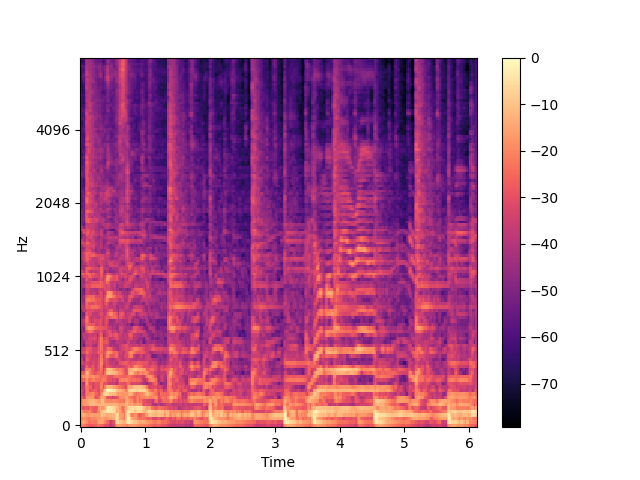
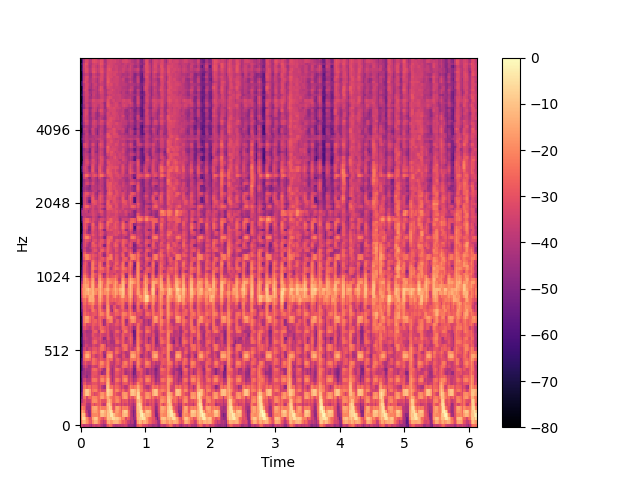
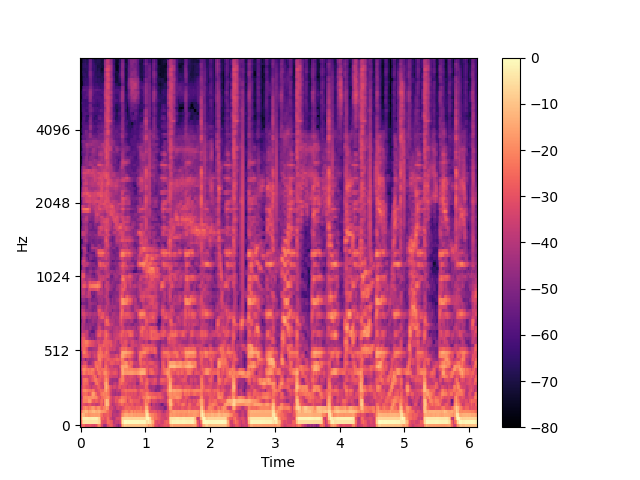
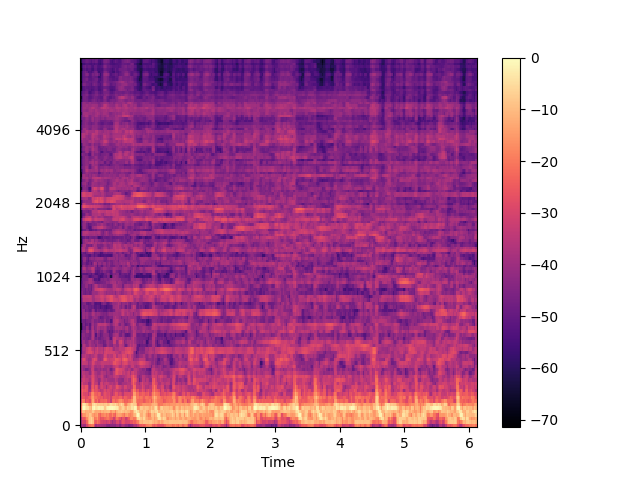
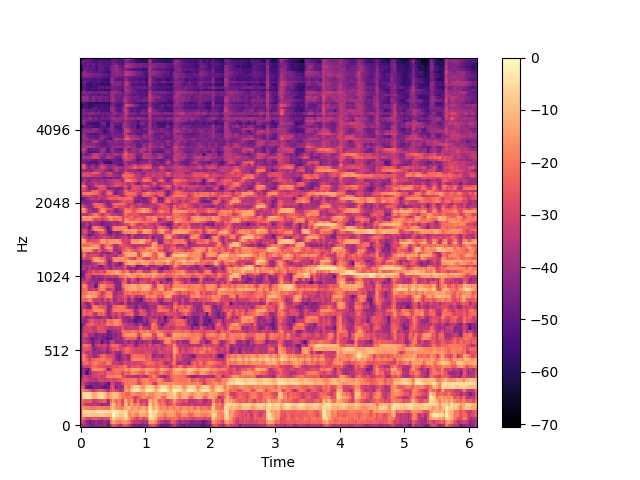
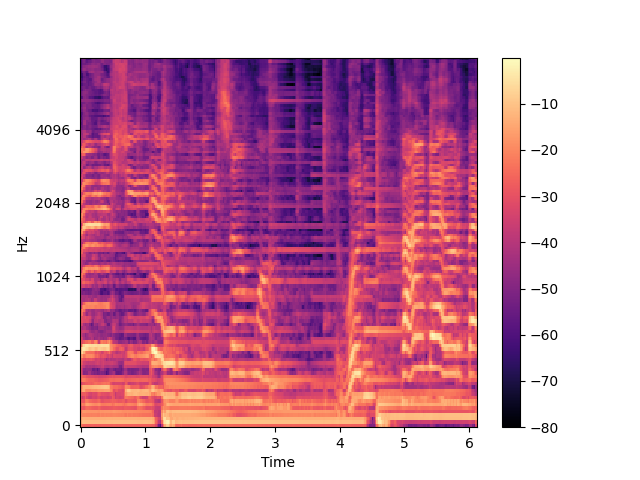

In [10]:
ipd.display(ipd.HTML(get_audio_browser_html(audio_browser_table_data)))

In [27]:
#print(table_html)

### Directly Display players, and plotly images

Showing Track:  118741 label is:  rock
Showing Track:  082076 label is:  electronic
Showing Track:  032957 label is:  hiphop
Showing Track:  050931 label is:  classical
Showing Track:  051935 label is:  jazz
Showing Track:  country.00034.wav label is:  country


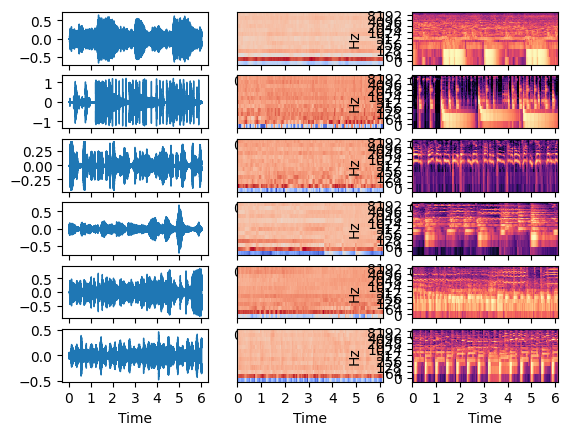

In [40]:
#to do: see if there is a way to filter out bad files 
#035394 - electronic? but more towards end 
#035453 - is jazz but doesn't sound like it 
#how to account fo music with differnet parts (predict each part and average the scores?)
audio.explore_features(12)

In [29]:
row_num = 0
track_id_ =audio.df['track_id'].iloc[row_num]
mfccs_ = audio.df['mfcc'].iloc[row_num]#[0: int(len(mfccs)/4)]
log_s_ =audio.df['log_melspectrogram'].iloc[row_num]
audio_ = audio.df['audio'].iloc[row_num]
sr_ = audio.df['sampling_rate'].iloc[row_num]
label_ = audio.df['label'].iloc[row_num]
print(label_)

rock


In [30]:
len(audio_), mfccs_.shape, log_s_.shape

(135000, (13, 264), (128, 264))

/var/folders/rt/w6xs9fcn3snbp_cdthc_kjww0000gq/T/ipykernel_41766/1519863365.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


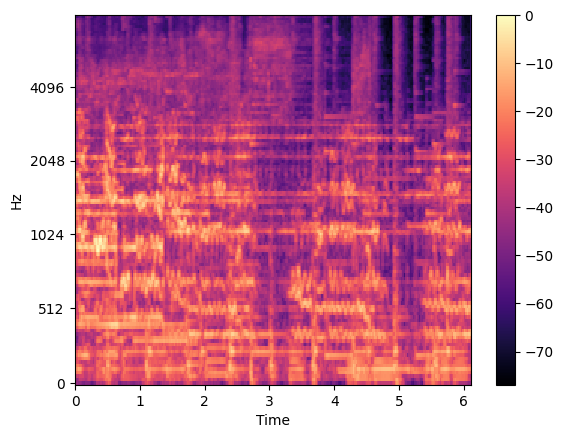

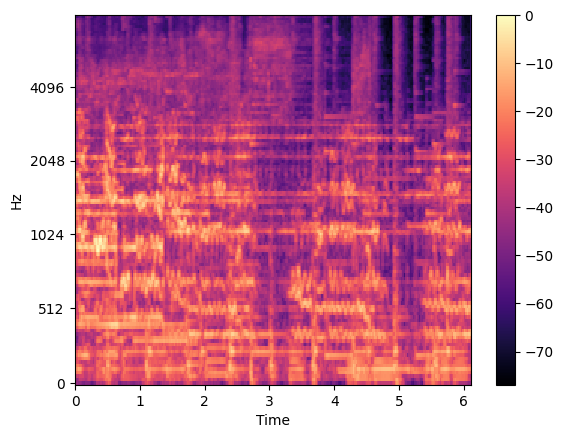

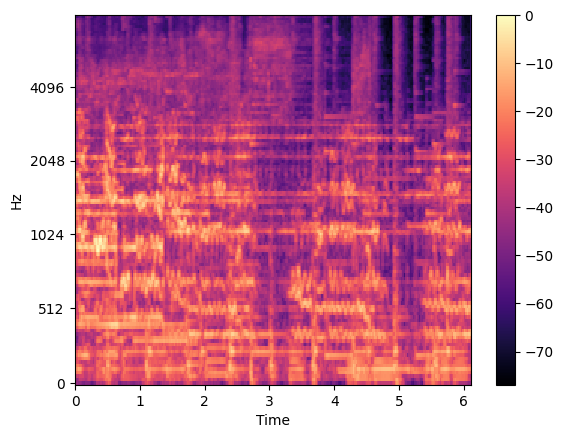

In [33]:
plt.ion()
fig, ax = plt.subplots()
spectro = librosa.display.specshow(log_s_,                                     x_axis='time', y_axis='mel', fmax=8000)
fig.colorbar(spectro, ax=ax)
fig.show()

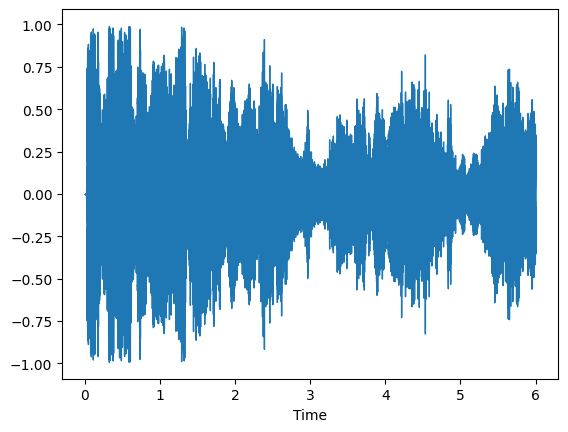

In [34]:
ipd.display(ipd.Audio(audio_, rate=sr_),
            librosa.display.waveshow(audio_, sr=sr_)                 
            )

In [35]:
mfccs_.shape, log_s_.shape

((13, 264), (128, 264))

[Text(0.5, 1.0, 'MFCC')]

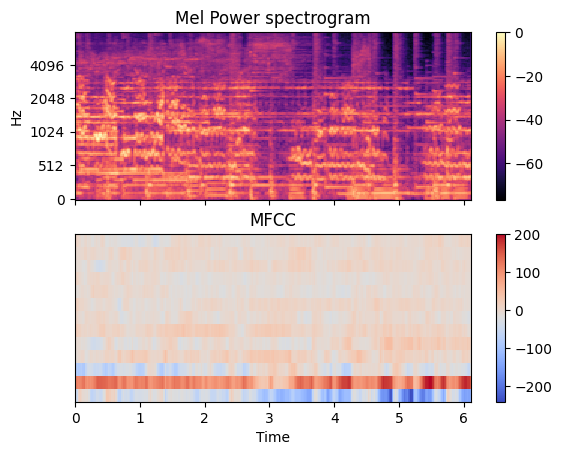

In [36]:
fig, ax = plt.subplots(nrows=2, sharex=True)
#'''
img = librosa.display.specshow(log_s_,
                               x_axis='time', y_axis='mel', fmax=8000,
                               ax=ax[0])
        
fig.colorbar(img, ax=[ax[0]])
#'''
ax[0].set(title='Mel Power spectrogram')
ax[0].label_outer()
img = librosa.display.specshow(mfccs_, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC')